In [ ]:
# default_exp funcs.predict

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from monai.inferers import sliding_window_inference
from decode_fish.funcs.plotting import *

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
cfg = OmegaConf.load(f'../config/experiment/BF_exmp_f1_max.yaml')

In [ ]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/lib/python3.9/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Crop size larger than volume in at least one dimension. Crop size changed to (23, 48, 48)
1 volumes


(<Figure size 495.072x447.286 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

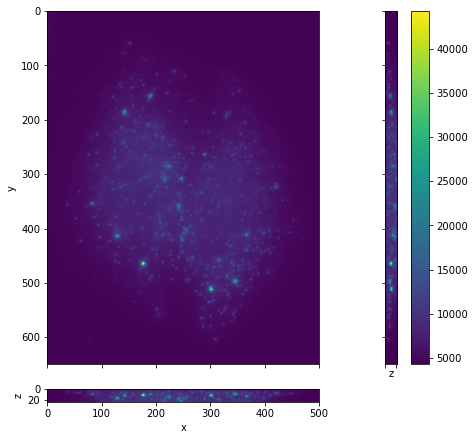

In [ ]:
plot_3d_projections(img_3d[0])

In [ ]:
# image_paths = sorted(glob.glob(str(Path(cfg.data_path.image_path).parent)+'/msp300*.tif'))
image_paths = sorted(glob.glob(str(Path(cfg.data_path.image_path).parent) + '/experiment_1_smfish_fov_1.tif'))
image_paths

['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/FQ/big-fish-examples/data/input/experiment_1_smfish_fov_1.tif']

In [ ]:
# export
def predict(model, post_proc, image_paths, sm_fish_ch=0, window_size=[None,128,128], device='cuda'):
    pred_df = DF()
    with torch.no_grad():
        for p in tqdm(image_paths):
            print(p.split('/')[-1])
            img = load_tiff_image(p)[sm_fish_ch]
            z, y, x = img.shape[-3:]
            img = img.reshape(-1,z,y,x)
            
            for i in range(len(img)):
                print(img[i][None,None].shape)
                output = sliding_window_inference(img[i][None,None], window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                # output = model.cpu()(img[i][None,None])
                output = model.tensor_to_dict(output)
                p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                i_df = post_proc.get_df(output, p_si)
                print('N. emitters: ', len(i_df))
                pred_df = append_emitter_df(pred_df, i_df)
                free_mem()
        return pred_df
    
def merfish_predict(model, post_proc, image_paths, window_size=[None,256,256], crop=np.s_[:,:,:,:,:], device='cuda'):
    pred_df = DF()
    with torch.no_grad():
        for p in image_paths:
#             print(p.split('/')[-1])
            if 'aligned' in p:
                from decode_fish.funcs.exp_specific import read_MOp_tiff
                img = read_MOp_tiff(p, scaled=True)[None]
            else:
                img = load_tiff_image(p)[None]

            n_chans = img.shape[1]
            print(img.shape)
            z, y, x = img.shape[-3:]
                
            inp = img[crop]
            output = sliding_window_inference(inp, window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            output = model.tensor_to_dict(output)
            p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            i_df = post_proc.get_df(output, p_si)
#             print('N. emitters: ', len(i_df))
            i_df.loc[:,'frame_idx'] = 0
            pred_df = append_emitter_df(pred_df, i_df)
            free_mem()
        return pred_df

In [ ]:
pred_df = predict(model, post_proc, image_paths)

  0%|                                                                         | 0/1 [00:00<?, ?it/s]

experiment_1_smfish_fov_1.tif
torch.Size([1, 1, 23, 650, 500])


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]

N. emitters:  735


In [ ]:
# with torch.no_grad():
#     output = sliding_window_inference(img[None], [37,128,128], 1, model.cuda(), overlap=0.2, sw_device ='cuda', device='cpu', mode='gaussian')
#     output = model.tensor_to_dict(output)
#     p_si = sliding_window_inference(output['logits'], [37,128,128], 1, post_proc, overlap=0.2, sw_device ='cuda', device='cpu', mode='gaussian')
#     pred_df = post_proc.get_df(output, p_si)

In [ ]:
# with torch.no_grad():
#     model.cpu()
#     res = model.tensor_to_dict(model(img[None]))
#     gt_df = post_proc.get_df(res)
#     free_mem()

In [ ]:
gt_df[:10]

In [ ]:
pred_df[:10]

In [ ]:
print(len(gt_df))
print(len(pred_df))

In [ ]:
from monai.data.utils import compute_importance_map, dense_patch_slices, get_valid_patch_size
from monai.utils import BlendMode, PytorchPadMode, fall_back_tuple
from typing import Any, Callable, List, Sequence, Tuple, Union
import torch.nn.functional as F
__all__ = ["sliding_window_inference"]


def sliding_window_inference(
    inputs: torch.Tensor,
    roi_size: Union[Sequence[int], int],
    sw_batch_size: int,
    predictor: Callable[..., torch.Tensor],
    overlap: float = 0.25,
    threshold: float = -1,
    mode: Union[BlendMode, str] = BlendMode.CONSTANT,
    sigma_scale: Union[Sequence[float], float] = 0.125,
    padding_mode: Union[PytorchPadMode, str] = PytorchPadMode.CONSTANT,
    cval: float = 0.0,
    sw_device: Union[torch.device, str, None] = None,
    device: Union[torch.device, str, None] = None,
    *args: Any,
    **kwargs: Any,
) -> torch.Tensor:
    """
    Sliding window inference on `inputs` with `predictor`.

    When roi_size is larger than the inputs' spatial size, the input image are padded during inference.
    To maintain the same spatial sizes, the output image will be cropped to the original input size.

    Args:
        inputs: input image to be processed (assuming NCHW[D])
        roi_size: the spatial window size for inferences.
            When its components have None or non-positives, the corresponding inputs dimension will be used.
            if the components of the `roi_size` are non-positive values, the transform will use the
            corresponding components of img size. For example, `roi_size=(32, -1)` will be adapted
            to `(32, 64)` if the second spatial dimension size of img is `64`.
        sw_batch_size: the batch size to run window slices.
        predictor: given input tensor `patch_data` in shape NCHW[D], `predictor(patch_data)`
            should return a prediction with the same spatial shape and batch_size, i.e. NMHW[D];
            where HW[D] represents the patch spatial size, M is the number of output channels, N is `sw_batch_size`.
        overlap: Amount of overlap between scans.
        mode: {``"constant"``, ``"gaussian"``}
            How to blend output of overlapping windows. Defaults to ``"constant"``.

            - ``"constant``": gives equal weight to all predictions.
            - ``"gaussian``": gives less weight to predictions on edges of windows.

        sigma_scale: the standard deviation coefficient of the Gaussian window when `mode` is ``"gaussian"``.
            Default: 0.125. Actual window sigma is ``sigma_scale`` * ``dim_size``.
            When sigma_scale is a sequence of floats, the values denote sigma_scale at the corresponding
            spatial dimensions.
        padding_mode: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}
            Padding mode for ``inputs``, when ``roi_size`` is larger than inputs. Defaults to ``"constant"``
            See also: https://pytorch.org/docs/stable/nn.functional.html#pad
        cval: fill value for 'constant' padding mode. Default: 0
        sw_device: device for the window data.
            By default the device (and accordingly the memory) of the `inputs` is used.
            Normally `sw_device` should be consistent with the device where `predictor` is defined.
        device: device for the stitched output prediction.
            By default the device (and accordingly the memory) of the `inputs` is used. If for example
            set to device=torch.device('cpu') the gpu memory consumption is less and independent of the
            `inputs` and `roi_size`. Output is on the `device`.
        args: optional args to be passed to ``predictor``.
        kwargs: optional keyword args to be passed to ``predictor``.

    Note:
        - input must be channel-first and have a batch dim, supports N-D sliding window.

    """
    num_spatial_dims = len(inputs.shape) - 2
    if overlap < 0 or overlap >= 1:
        raise AssertionError("overlap must be >= 0 and < 1.")

    # determine image spatial size and batch size
    # Note: all input images must have the same image size and batch size
    image_size_ = list(inputs.shape[2:])
    batch_size = inputs.shape[0]

    if device is None:
        device = inputs.device
    if sw_device is None:
        sw_device = inputs.device

    roi_size = fall_back_tuple(roi_size, image_size_)
    # in case that image size is smaller than roi size
    image_size = tuple(max(image_size_[i], roi_size[i]) for i in range(num_spatial_dims))
    pad_size = []
    for k in range(len(inputs.shape) - 1, 1, -1):
        diff = max(roi_size[k - 2] - inputs.shape[k], 0)
        half = diff // 2
        pad_size.extend([half, diff - half])
    inputs = F.pad(inputs, pad=pad_size, mode=PytorchPadMode(padding_mode).value, value=cval)

    scan_interval = _get_scan_interval(image_size, roi_size, num_spatial_dims, overlap)

    # Store all slices in list
    slices = dense_patch_slices(image_size, roi_size, scan_interval)
    num_win = len(slices)  # number of windows per image
    total_slices = num_win * batch_size  # total number of windows

    # Create window-level importance map
    importance_map = compute_importance_map(
        get_valid_patch_size(image_size, roi_size), mode=mode, sigma_scale=sigma_scale, device=device
    )
    window_output_shape = None
    counter = 0

    # Perform predictions
    output_image, count_map = torch.tensor(0.0, device=device), torch.tensor(0.0, device=device)
    _initialized = False
    for slice_g in range(0, total_slices, sw_batch_size):
        slice_range = range(slice_g, min(slice_g + sw_batch_size, total_slices))
        unravel_slice = [
            [slice(int(idx / num_win), int(idx / num_win) + 1), slice(None)] + list(slices[idx % num_win])
            for idx in slice_range
        # ]
        window_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
        if window_data.max() > threshold or window_output_shape is None:
            seg_prob = predictor(window_data, *args, **kwargs).to(device)  # batched patch segmentation
            window_output_shape = seg_prob.shape
            counter += 1
        else:
            seg_prob = torch.zeros(window_output_shape) - 100

        if not _initialized:  # init. buffer at the first iteration
            output_classes = seg_prob.shape[1]
            output_shape = [batch_size, output_classes] + list(image_size)
            # allocate memory to store the full output and the count for overlapping parts
            output_image = torch.zeros(output_shape, dtype=torch.float32, device=device)
            count_map = torch.zeros(output_shape, dtype=torch.float32, device=device)
            _initialized = True

        # store the result in the proper location of the full output. Apply weights from importance map.
        for idx, original_idx in zip(slice_range, unravel_slice):
            output_image[original_idx] += importance_map * seg_prob[idx - slice_g]
            count_map[original_idx] += importance_map

    # account for any overlapping sections
    output_image = output_image / count_map

    final_slicing: List[slice] = []
    for sp in range(num_spatial_dims):
        slice_dim = slice(pad_size[sp * 2], image_size_[num_spatial_dims - sp - 1] + pad_size[sp * 2])
        final_slicing.insert(0, slice_dim)
    while len(final_slicing) < len(output_image.shape):
        final_slicing.insert(0, slice(None))
        
    print(counter)
    return output_image[final_slicing]


def _get_scan_interval(
    image_size: Sequence[int], roi_size: Sequence[int], num_spatial_dims: int, overlap: float
) -> Tuple[int, ...]:
    """
    Compute scan interval according to the image size, roi size and overlap.
    Scan interval will be `int((1 - overlap) * roi_size)`, if interval is 0,
    use 1 instead to make sure sliding window works.

    """
    if len(image_size) != num_spatial_dims:
        raise ValueError("image coord different from spatial dims.")
    if len(roi_size) != num_spatial_dims:
        raise ValueError("roi coord different from spatial dims.")

    scan_interval = []
    for i in range(num_spatial_dims):
        if roi_size[i] == image_size[i]:
            scan_interval.append(int(roi_size[i]))
        else:
            interval = int(roi_size[i] * (1 - overlap))
            scan_interval.append(interval if interval > 0 else 1)
    return tuple(scan_interval)

In [ ]:
# export
def selective_predict(model, post_proc, image_paths, window_size=[None, 128, 128], threshold=-1e6, device='cuda'):
    pred_df = DF()
    with torch.no_grad():
        for p in tqdm(image_paths):
            print(p.split('/')[-1])
            img = load_tiff_image(p)
            z,y,x = img.shape[-3:]
            img = img.reshape(-1,z,y,x)
            for i in range(len(img)):
                print(img[i][None,None].shape)
                output = sliding_window_inference(img[i][None,None], window_size, sw_batch_size=1, predictor=model.to(device), overlap=0.2, threshold=threshold, sw_device=device, device='cpu', mode='gaussian')
                # output = model.cpu()(img[i][None,None])
                output = model.tensor_to_dict(output)
                p_si = sliding_window_inference(output['logits'], window_size, sw_batch_size=1, predictor=post_proc, overlap=0.2, threshold=-5, sw_device=device, device='cpu', mode='gaussian')
                i_df = post_proc.get_df(output, p_si)
                print('N. emitters: ', len(i_df))
                pred_df = append_emitter_df(pred_df, i_df)
                free_mem()
        return pred_df

In [ ]:
t0 = time.time()
for _ in range(5):
    pred_df = selective_predict(model, post_proc, image_paths, threshold=0)
print(time.time() - t0)

  0%|                                                                         | 0/1 [00:00<?, ?it/s]

experiment_1_smfish_fov_1.tif
torch.Size([1, 1, 23, 650, 500])
130


  0%|                                                                         | 0/1 [00:00<?, ?it/s]

84
N. emitters:  737
experiment_1_smfish_fov_1.tif
torch.Size([1, 1, 23, 650, 500])
130


  0%|                                                                         | 0/1 [00:00<?, ?it/s]

84
N. emitters:  737
experiment_1_smfish_fov_1.tif
torch.Size([1, 1, 23, 650, 500])
130


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]

84
N. emitters:  737



  0%|                                                                         | 0/1 [00:00<?, ?it/s]

experiment_1_smfish_fov_1.tif
torch.Size([1, 1, 23, 650, 500])
130


  0%|                                                                         | 0/1 [00:00<?, ?it/s]

84
N. emitters:  737
experiment_1_smfish_fov_1.tif
torch.Size([1, 1, 23, 650, 500])
130
84
N. emitters:  737


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]

12.249284982681274


In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.
